Application showing the interpolation of a single species, _Biddulphia Sinensis_.       
The interpolation of the full dataset (loop, plots and netCDF generation) is performed in [`interp_presence_absence_prod`](interp_presence_absence_prod.ipynb)

In [1]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
include("../scripts/PhytoInterp.jl")
doplot = true

true

## Files and directories

In [2]:
figdir = "./figures/"
outputdir = "../product/"
datadir = "./data/"
datafile = joinpath(datadir, "Biddulphia sinensis-1995-2020.csv")
isdir(datadir) ? " " : mkpath(datadir)
isdir(figdir) ? " " : mkpath(figdir)
isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

"./data/Biddulphia sinensis-1995-2020.csv"

## Prepare mask
### Interpolation grid

In [3]:
longrid = -2.:0.1:10.
latgrid = 51.:0.1:56.

51.0:0.1:56.0

### Download file

In [4]:
bathname = "./data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[4]:5


### Read bathymetry

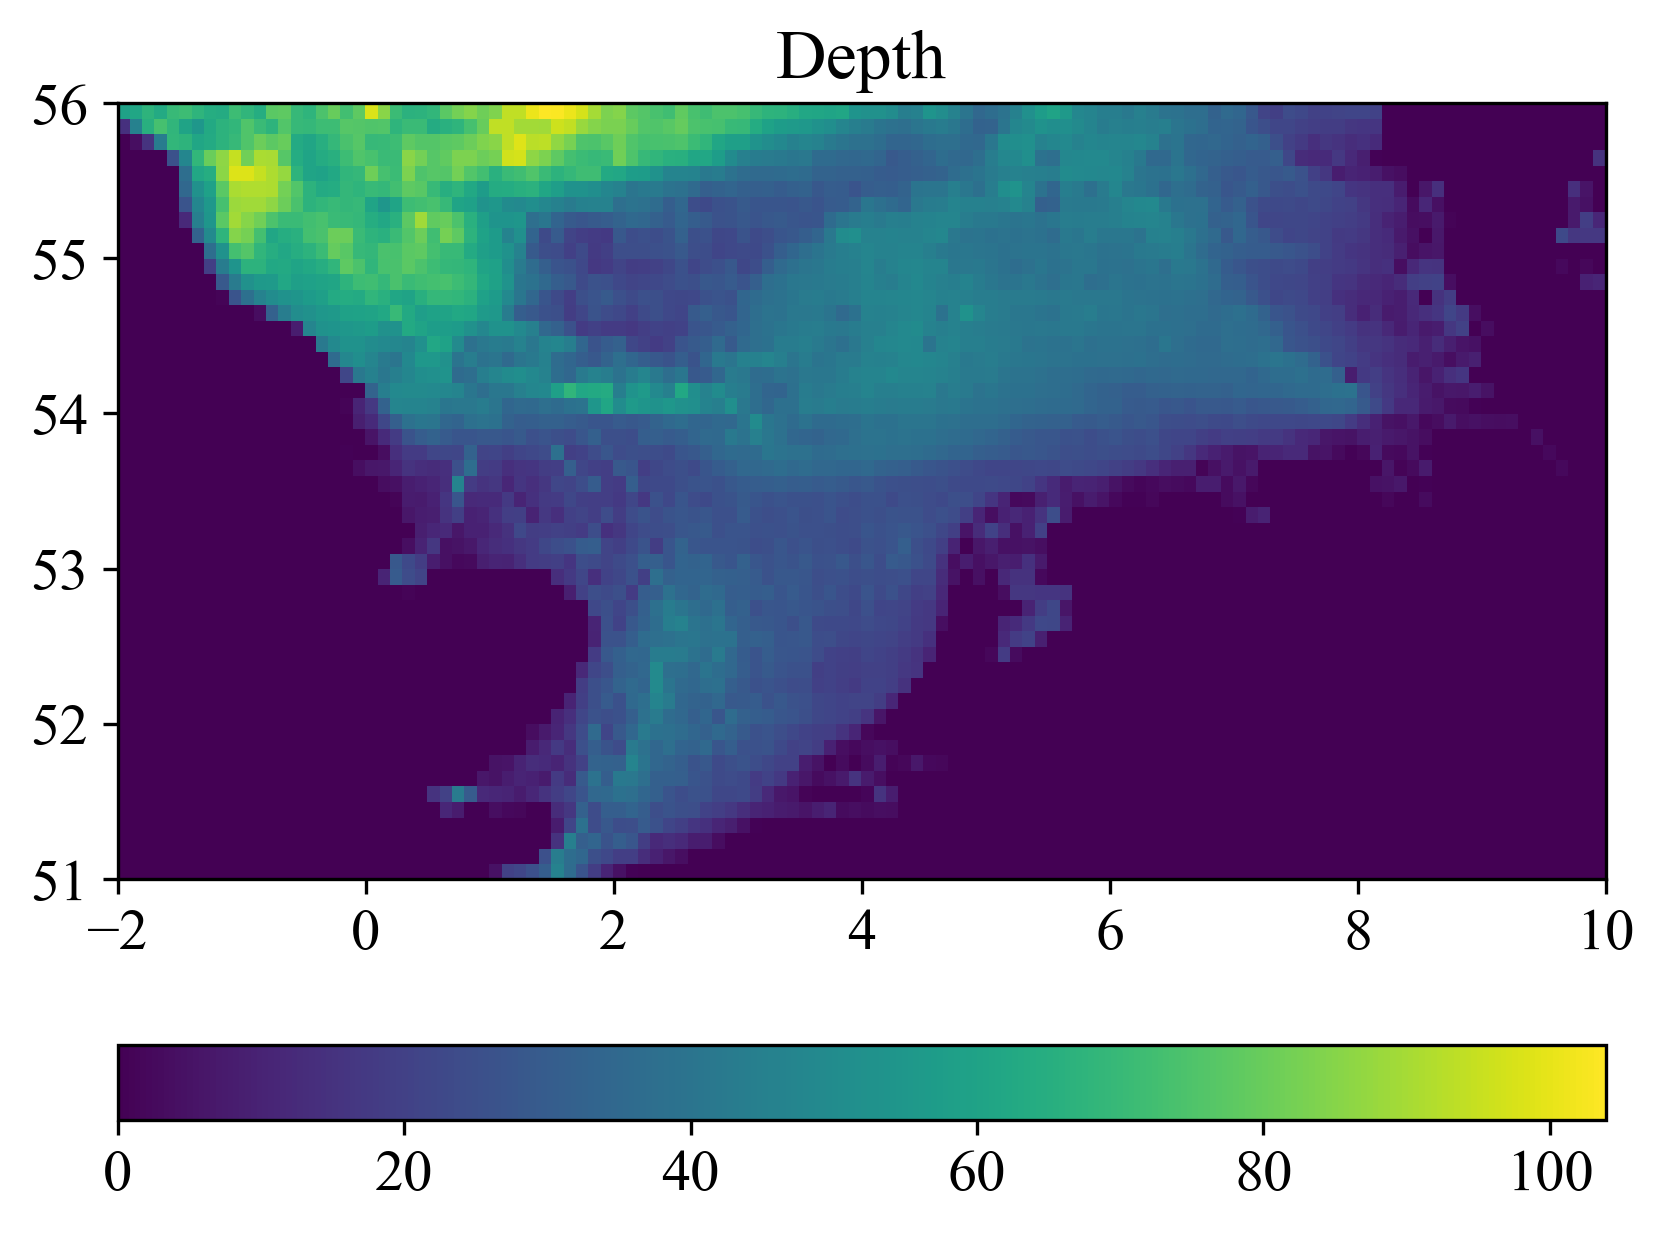

size(b) = (121, 51)


In [5]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111)
    pcolor(bx,by,b', vmin=0.); 
    colorbar(orientation="horizontal")
    title("Depth")
    show()
end

### Metrics

In [6]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Interpolation

In [8]:
speciesname = get_species_name(basename(datafile))
speciesslug = get_species_slug(basename(datafile))
@info("Working on $(speciesname)")
        
# Data reading
dates, lons, lats, occurs = read_data_phyto(datafile);

# Conversion of coordinates
lon, lat = transform_coords(lons, lats)

data_presence = occurs .== 1;
data_absence = .!(data_presence);
npre = sum(data_presence)
nabs = sum(data_absence);
@info("Presence: $(npre), absence: $(nabs)");

┌ Info: Working on Biddulphia sinensis
└ @ Main In[8]:3
┌ Info: Presence: 6957, absence: 18820
└ @ Main In[8]:15


### Compute heatmap
We compute: 
1. the heatmap using all the observation (presence or absence),
2. the heatmap using only the presence observations,
3. the heatmap only the absence observations.

The first provives an indication of the sampling effort: high values in an area means a lot of measurements have been made in that area. This could be used to adapt the inflation vector, which is filled with 1's by default.      To to so, the heatmap has to be interpolated at the location of the observations.

In [9]:
inflation = ones(length(lon));
@time dens1, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon, lat), inflation, 0.2);
@time dens2, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_presence], lat[data_presence]), inflation[data_presence], 0.2);
@time dens3, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_absence], lat[data_absence]), inflation[data_absence], 0.2);

┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 25.007306 seconds (58.49 M allocations: 3.927 GiB, 5.19% gc time)
  3.610930 seconds (621.36 k allocations: 4.755 GiB, 4.02% gc time)


┌ Warning: Data array size (18820,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


  1.194576 seconds (701.79 k allocations: 1.013 GiB, 26.08% gc time)


Finally, the density field is computed as:
```
d = npre * dens2 / (npre * dens2 + nabs * dens3)
```
The reason for this equation is that the heatmap are computed so that their integral over the domain is 1, whatever the number of observations. 

In [12]:
d = npre .* dens2 ./ (npre .* dens2 .+ nabs .* dens3);

### Plotting

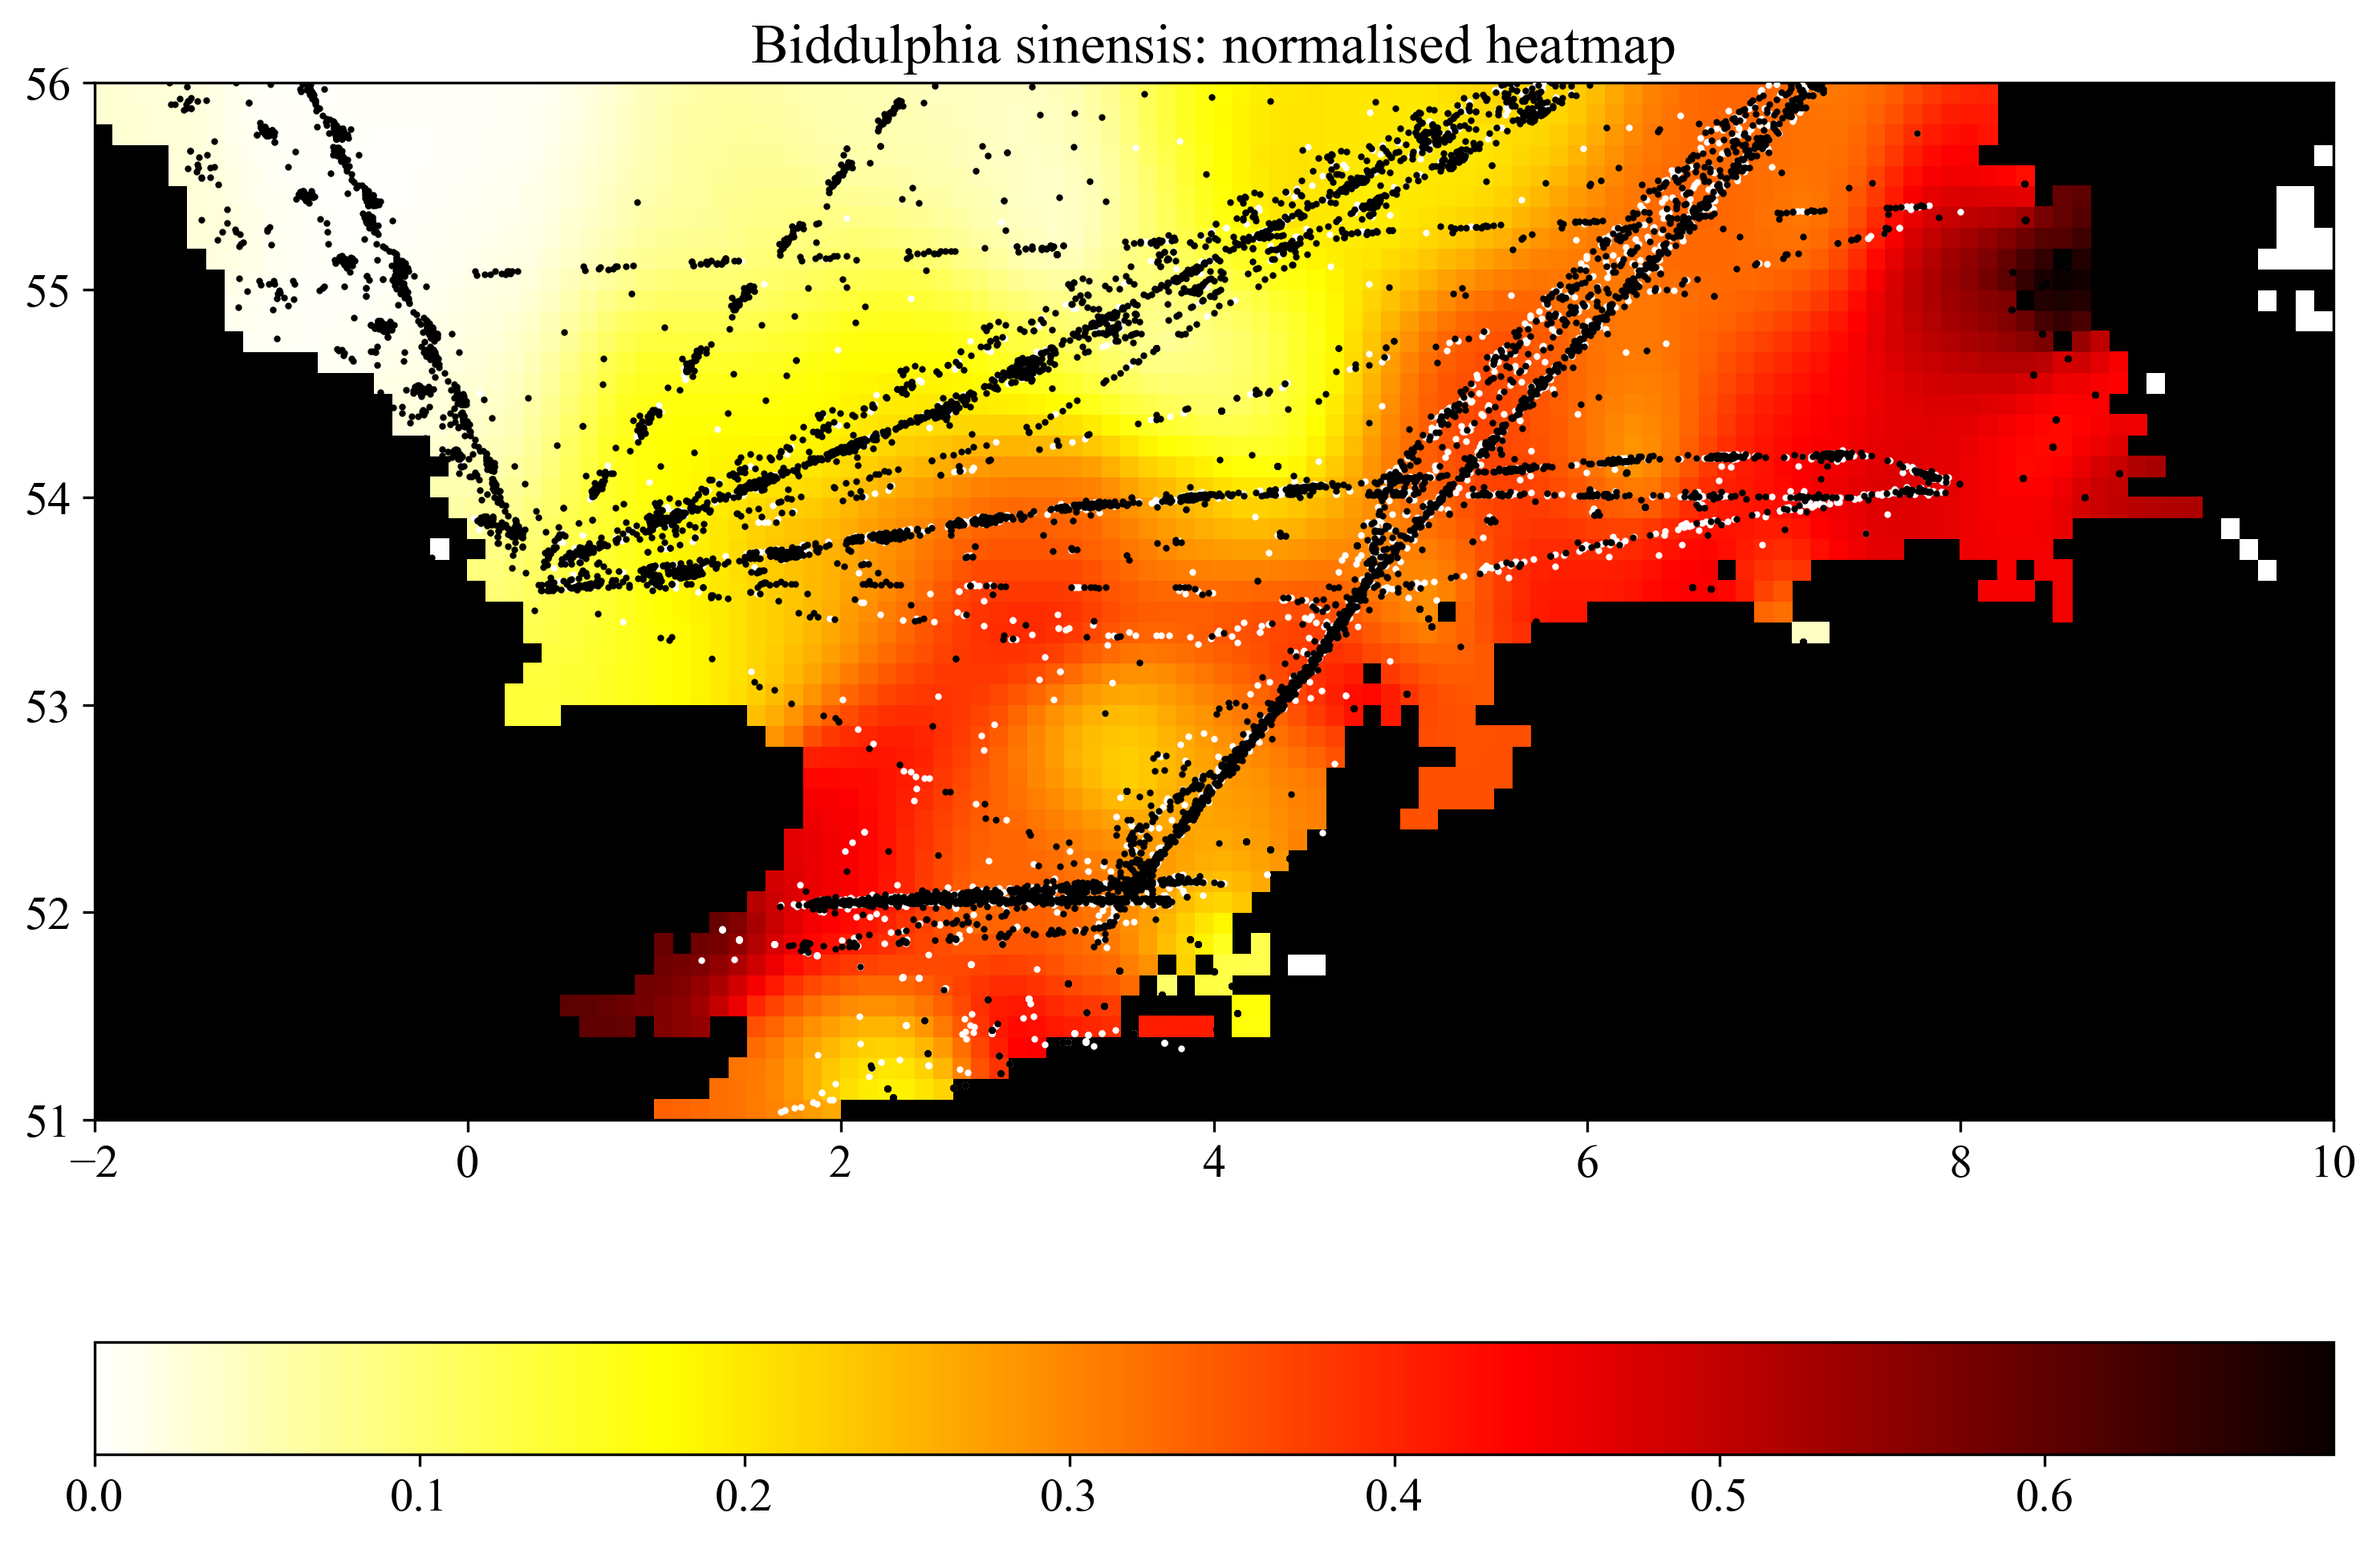

PyObject <matplotlib.collections.QuadMesh object at 0x7fed02dc1a10>

In [18]:
if doplot
    plot_heatmap(longrid, latgrid, d, lon, lat, occurs,
        "$(speciesname): normalised heatmap")
    pcolormesh(longrid, latgrid, mask', cmap=PyPlot.cm.binary_r)
end

### Write results in netCDF

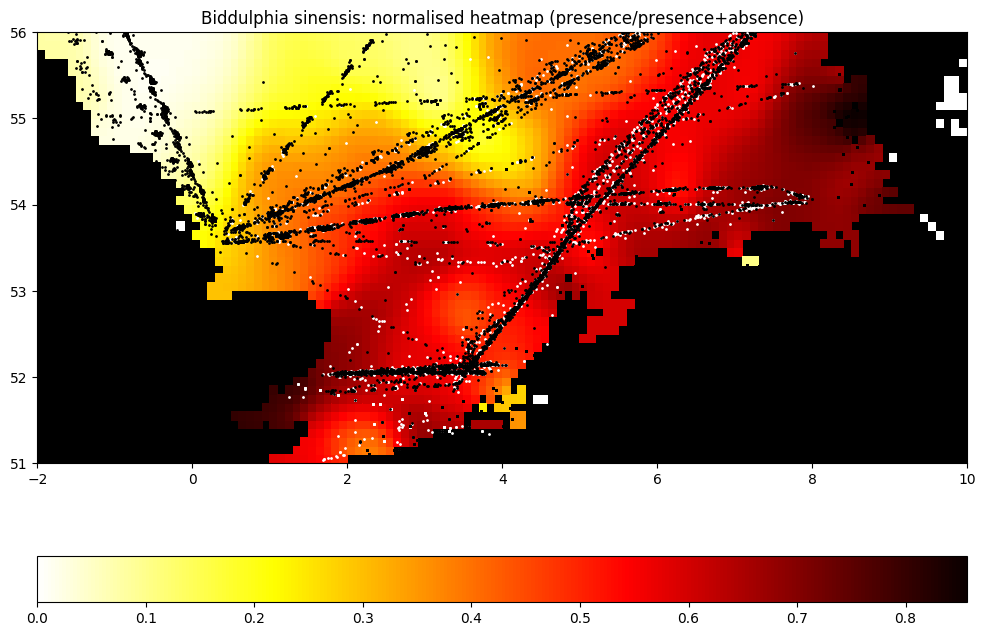

In [28]:
create_nc_results(joinpath(outputdir, "$(speciesname)_heatmap.nc"), 
    longrid, latgrid, dens2 ./ (dens2 .+ dens3), speciesname);